<a href="https://colab.research.google.com/github/Android998/TensorFlow2.3/blob/master/TFG5.0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **Paso 1: Importar las librerias**

In [1]:
import os
import zipfile
import numpy as np
import tensorflow as tf
assert tf.__version__.startswith('2')
import matplotlib.pyplot as plt

from tqdm import tqdm_notebook
from google.colab import drive
from tensorflow.keras.preprocessing.image import ImageDataGenerator

%matplotlib inline

## **Paso 2:Pre procesado de datos**

In [2]:
drive.mount("/content/drive")
base_dir = "./drive/My Drive/object_photos"

Mounted at /content/drive


In [3]:
IMAGE_SIZE = 224
BATCH_SIZE = 64
datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255, 
    validation_split=0.2)


In [4]:
train_generator = datagen.flow_from_directory(
    base_dir,
    target_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE, 
    subset='training')

print(len(train_generator))

Found 38205 images belonging to 40 classes.
597


In [5]:
val_generator = datagen.flow_from_directory(
    base_dir,
    target_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE, 
    subset='validation')
print(len(val_generator))

Found 9533 images belonging to 40 classes.
149


In [6]:
for image_batch, label_batch in train_generator:
  break
image_batch.shape, label_batch.shape

((64, 224, 224, 3), (64, 40))

### **Generamos el archivo labels con las etiquetas de los objetos**

In [7]:
print (train_generator.class_indices)

labels = '\n'.join(sorted(train_generator.class_indices.keys()))

with open('labels.txt', 'w') as f:
  f.write(labels)

{'backpack': 0, 'bed': 1, 'belt': 2, 'blind stick': 3, 'bottle': 4, 'carpet': 5, 'cellular phone': 6, 'chair': 7, 'cup-glass': 8, 'door': 9, 'eyeglasses': 10, 'fan': 11, 'handkerchief': 12, 'headphones': 13, 'keys': 14, 'laptop': 15, 'mouse': 16, 'newspaper': 17, 'notebook': 18, 'pen': 19, 'pencil': 20, 'pillow': 21, 'plate': 22, 'plug': 23, 'printer': 24, 'radiator': 25, 'remote control': 26, 'shoes': 27, 'shorts': 28, 'socks': 29, 't-shirt': 30, 'table': 31, 'television': 32, 'toothbrush': 33, 'towel': 34, 'trash bin': 35, 'wallet': 36, 'wardrobe': 37, 'watch': 38, 'window (shade)': 39}


## **Paso 3: Crear el modelo base ya entrenado**

In [9]:
IMG_SHAPE = (IMAGE_SIZE, IMAGE_SIZE, 3)

# Create the base model from the pre-trained model MobileNet V2
base_model = tf.keras.applications.NASNetMobile(input_shape=IMG_SHAPE,
                                              include_top=False, 
                                              weights='imagenet')

19996672/19993432 [==============================] - 0s 0us/step


In [10]:
base_model.summary()

Model: "NASNet"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
stem_conv1 (Conv2D)             (None, 111, 111, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
stem_bn1 (BatchNormalization)   (None, 111, 111, 32) 128         stem_conv1[0][0]                 
__________________________________________________________________________________________________
activation (Activation)         (None, 111, 111, 32) 0           stem_bn1[0][0]                   
_____________________________________________________________________________________________

### **Añadir ultima capa**

In [11]:
base_model.trainable = False

In [12]:
model = tf.keras.Sequential([
  base_model,
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.Dropout(0.2),
  tf.keras.layers.GlobalAveragePooling2D(),
  tf.keras.layers.Dense(40, activation='softmax')
])

In [13]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
NASNet (Functional)          (None, 7, 7, 1056)        4269716   
_________________________________________________________________
conv2d (Conv2D)              (None, 5, 5, 32)          304160    
_________________________________________________________________
dropout (Dropout)            (None, 5, 5, 32)          0         
_________________________________________________________________
global_average_pooling2d (Gl (None, 32)                0         
_________________________________________________________________
dense (Dense)                (None, 40)                1320      
Total params: 4,575,196
Trainable params: 305,480
Non-trainable params: 4,269,716
_________________________________________________________________


### **Compilar y entrenar el modelo**

In [14]:
model.compile(optimizer=tf.keras.optimizers.Adam(lr=0.0001),
              loss='categorical_crossentropy', 
              metrics=['accuracy'])

In [15]:
callback = tf.keras.callbacks.EarlyStopping(
    monitor = "val_loss", patience = 10, mode = "auto", 
    restore_best_weights = True
)

In [17]:
history = model.fit(train_generator, 
                    steps_per_epoch=len(train_generator), 
                    epochs=100,
                    callbacks = [callback], 
                    validation_data=val_generator, 
                    validation_steps=len(val_generator))

Epoch 1/100
306/597 [==============>...............] - ETA: 40:25 - loss: 0.7023 - accuracy: 0.8141

UnknownError: ignored

### **Evaluar el modelo**

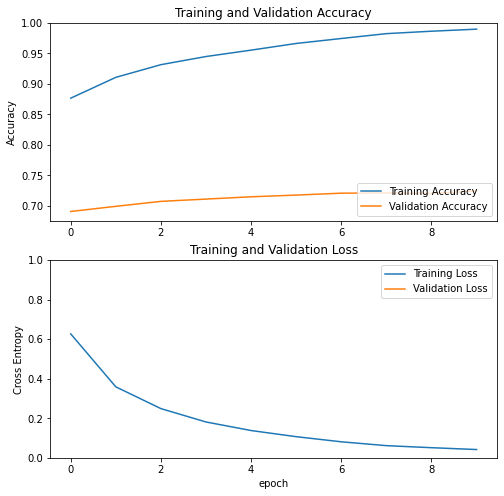

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

## **Paso 4: Fine Tuning**

In [ ]:
base_model.trainable = True

In [ ]:
print("Number of layersin the base model: {}".format(len(base_model.layers)))

Number of layersin the base model: 155


In [ ]:
fine_tune_at = 80

In [ ]:
for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False

### **Compilar y entrenar el modelo**

In [ ]:
model.compile(optimizer=tf.keras.optimizers.Adam(lr=0.0001), loss="categorical_crossentropy", metrics=["accuracy"])

In [ ]:
history = model.fit(train_generator, 
                    steps_per_epoch=len(train_generator), 
                    epochs=20, 
                    validation_data=val_generator, 
                    validation_steps=len(val_generator))

Epoch 1/20
201/201 [==============================] - 88s 437ms/step - loss: 0.1449 - accuracy: 0.9561 - val_loss: 2.5297 - val_accuracy: 0.6581
Epoch 2/20
201/201 [==============================] - 87s 434ms/step - loss: 0.0519 - accuracy: 0.9845 - val_loss: 2.4882 - val_accuracy: 0.6944
Epoch 3/20
201/201 [==============================] - 87s 435ms/step - loss: 0.0362 - accuracy: 0.9885 - val_loss: 2.4885 - val_accuracy: 0.6841
Epoch 4/20
201/201 [==============================] - 88s 438ms/step - loss: 0.0296 - accuracy: 0.9916 - val_loss: 2.1538 - val_accuracy: 0.7188
Epoch 5/20
201/201 [==============================] - 87s 433ms/step - loss: 0.0268 - accuracy: 0.9922 - val_loss: 2.1917 - val_accuracy: 0.7275
Epoch 6/20
201/201 [==============================] - 87s 432ms/step - loss: 0.0226 - accuracy: 0.9929 - val_loss: 2.0580 - val_accuracy: 0.7513
Epoch 7/20
201/201 [==============================] - 88s 437ms/step - loss: 0.0239 - accuracy: 0.9926 - val_loss: 2.4013 - val_ac

### **Evaluacion de resultados**

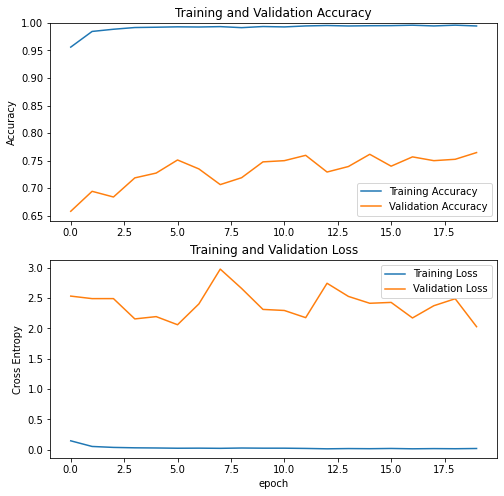

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

### **Seguimos entrenando ya que aun hay margen de mejora**

In [ ]:
model.compile(optimizer=tf.keras.optimizers.Adam(lr=0.00001), loss="categorical_crossentropy", metrics=["accuracy"])

In [ ]:
history = model.fit(train_generator, 
                    steps_per_epoch=len(train_generator), 
                    epochs=5, 
                    validation_data=val_generator, 
                    validation_steps=len(val_generator))

Epoch 1/5
1601/1601 [==============================] - 88s 55ms/step - loss: 0.0394 - accuracy: 0.9880 - val_loss: 1.2626 - val_accuracy: 0.8056
Epoch 2/5
1601/1601 [==============================] - 85s 53ms/step - loss: 0.0382 - accuracy: 0.9881 - val_loss: 1.3492 - val_accuracy: 0.8009
Epoch 3/5
1601/1601 [==============================] - 87s 54ms/step - loss: 0.0360 - accuracy: 0.9879 - val_loss: 1.2930 - val_accuracy: 0.8059
Epoch 4/5
1601/1601 [==============================] - 87s 55ms/step - loss: 0.0332 - accuracy: 0.9890 - val_loss: 1.3321 - val_accuracy: 0.8050
Epoch 5/5
1601/1601 [==============================] - 87s 55ms/step - loss: 0.0272 - accuracy: 0.9917 - val_loss: 1.3426 - val_accuracy: 0.8025


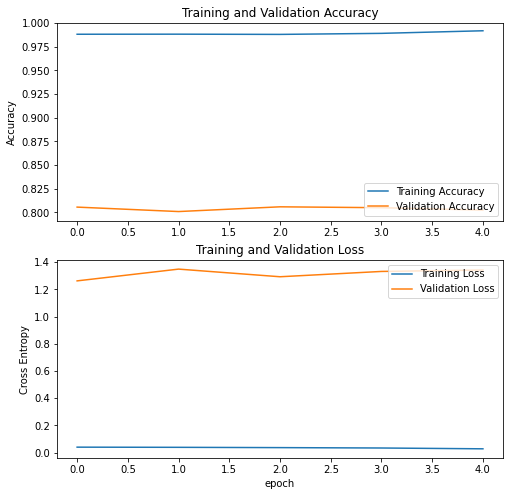

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

### **Cargar el modelo de TFLite**

In [ ]:
saved_model_dir = 'save/fine_tuning'
tf.saved_model.save(model, saved_model_dir)

converter = tf.lite.TFLiteConverter.from_saved_model(saved_model_dir)
tflite_model = converter.convert()

with open('model.tflite', 'wb') as f:
  f.write(tflite_model)

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.


Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.


Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.


Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.


INFO:tensorflow:Assets written to: save/fine_tuning/assets


INFO:tensorflow:Assets written to: save/fine_tuning/assets


In [ ]:
from google.colab import files

files.download('model.tflite')
files.download('labels.txt')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>